<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/Basic_test_complete_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# User Parameters

In [4]:
dataset_size = 10000
load_models = True

In [5]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/'

# CNN Network 

In [6]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [7]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [8]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], 1) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  print(model.summary())
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  model.save(filename)
  return model


In [9]:
def getmodel(X_train, y_train, filename, loadmodel=False):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    model = compile_and_train(X_train, y_train, filename, no_kernels=2)
    

  return model

# Continous Wave

## Helper functions

In [10]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [11]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [12]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [13]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

### Prediction

In [14]:
def test_and_predict(model, X_test, y_test):
  X_test = np.expand_dims(X_test, axis=2)
  model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict


In [15]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

## Main section

In [16]:
df_iterations = makerandom(dataset_size)

In [17]:
traces_clean = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

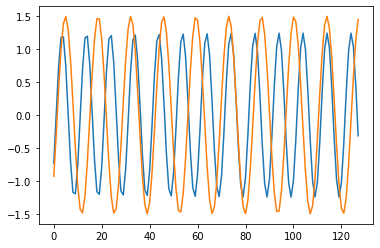

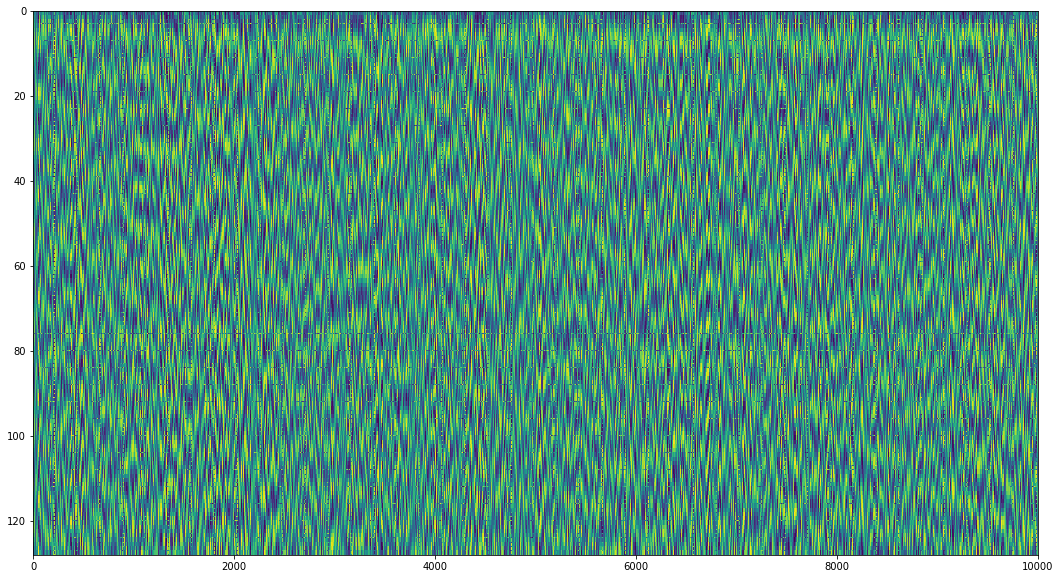

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_cw_clean


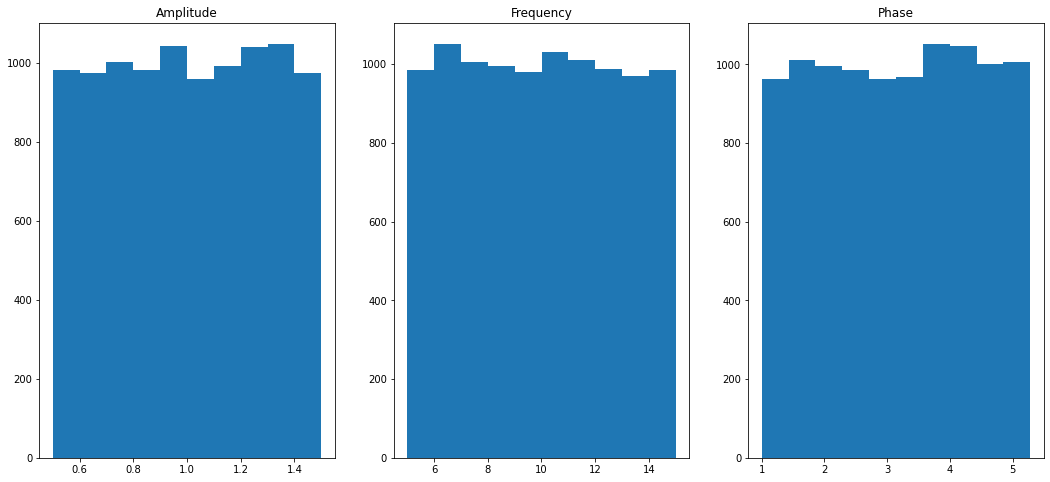

In [18]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False)
model_cw_clean = getmodel(X_train, y_train, filename=path+'model_cw_clean', loadmodel=load_models)

63/63 [==============================] - 15s 3ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0628


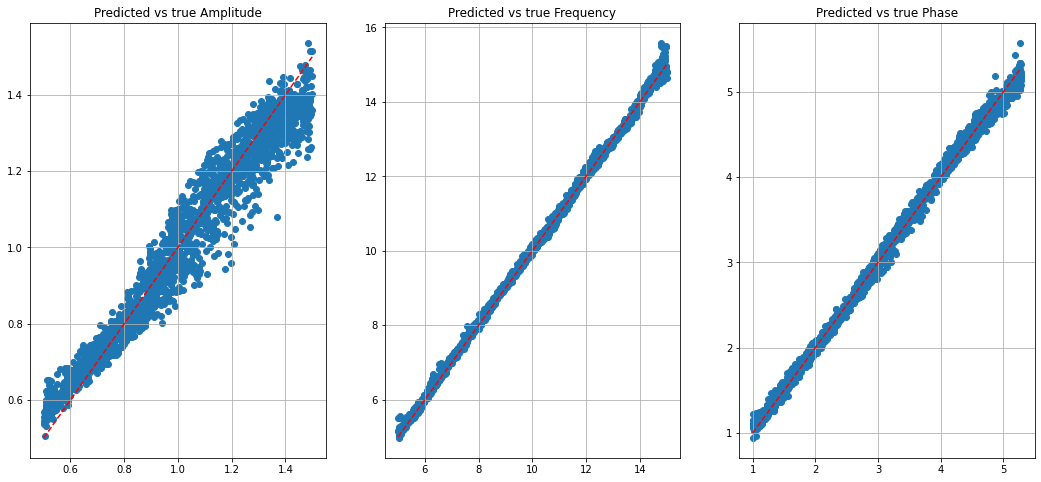

In [19]:
df_y_predict = test_and_predict(model_cw_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

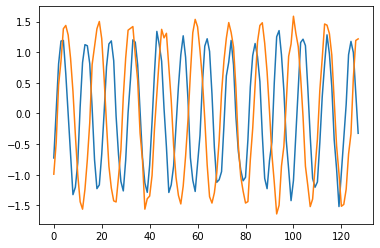

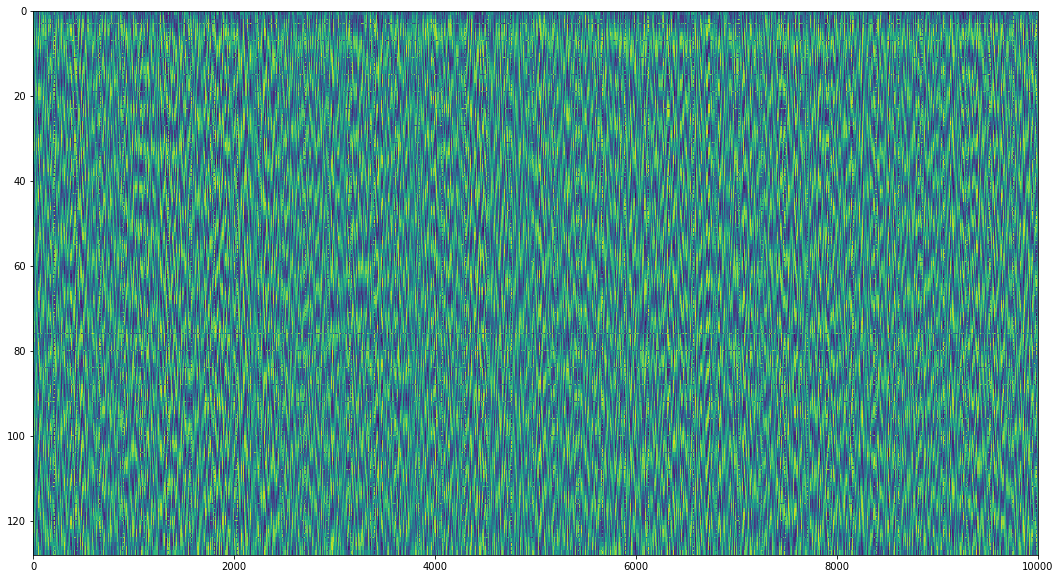

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_cw_noisy


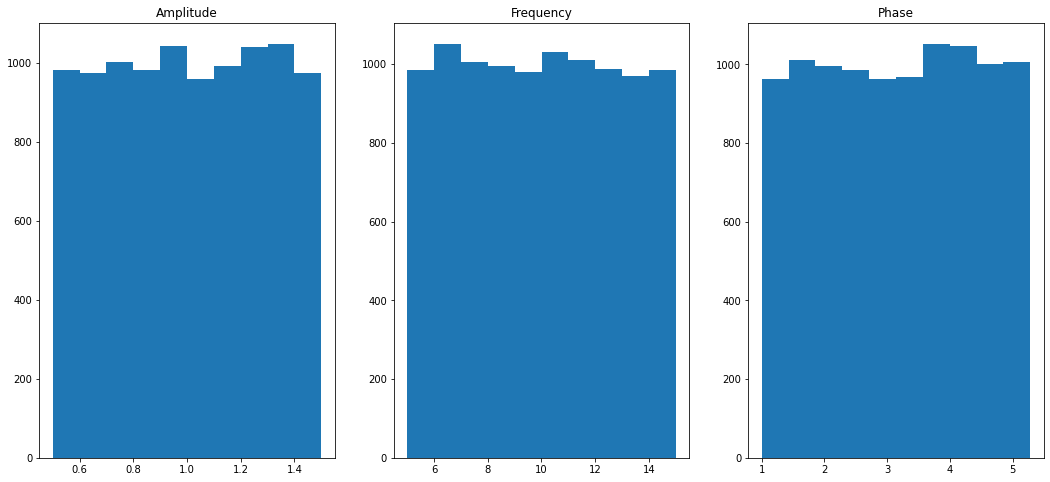

In [20]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=True)
model_cw_noisy = getmodel(X_train, y_train, filename=path+'model_cw_noisy', loadmodel=load_models)

63/63 [==============================] - 1s 3ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0853


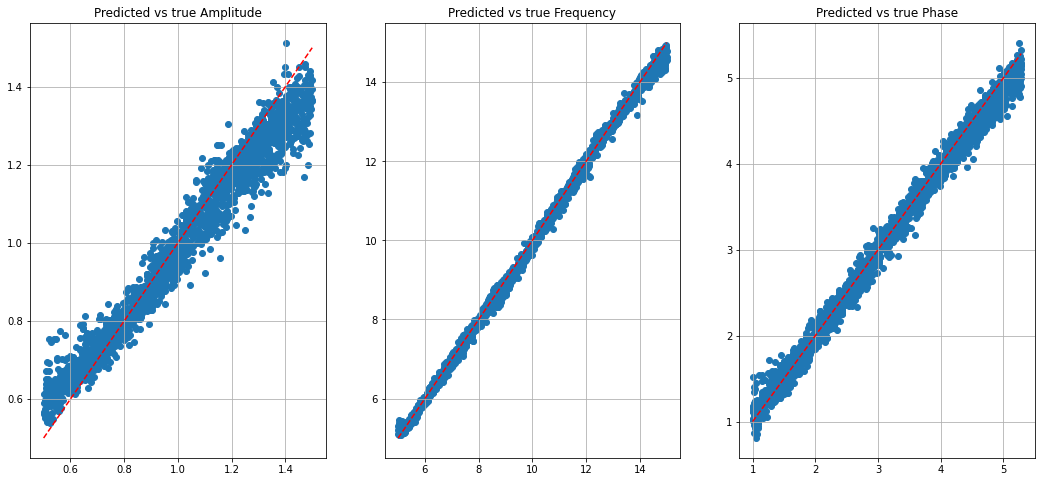

In [21]:
df_y_predict = test_and_predict(model_cw_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Signal Pulse

## Helper functions

In [22]:
from scipy import signal
from scipy.fft import fft, fftshift

In [23]:
def makepulse(amp, freq, phase, samplingfreq=128, std=9, t_end=1):
  dt = 1/samplingfreq
  #t_end = samples*dt
  samples = t_end/dt
  t_array = np.arange(0, t_end, dt)
  window = signal.windows.gaussian(samples, std)
  y = amp*np.cos(2*np.pi*freq*t_array + phase) * window
  return y

## Main section

In [24]:
pulse_traces_clean = [makepulse(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

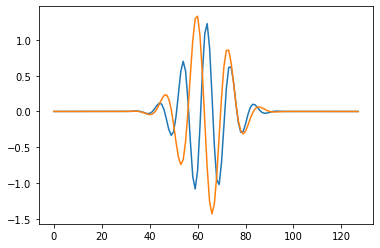

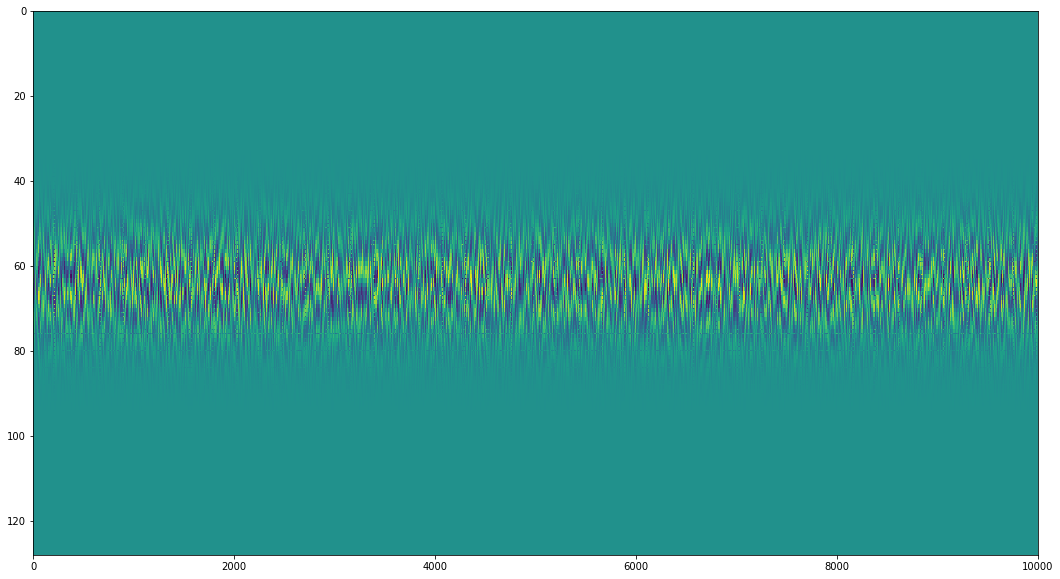

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_clean


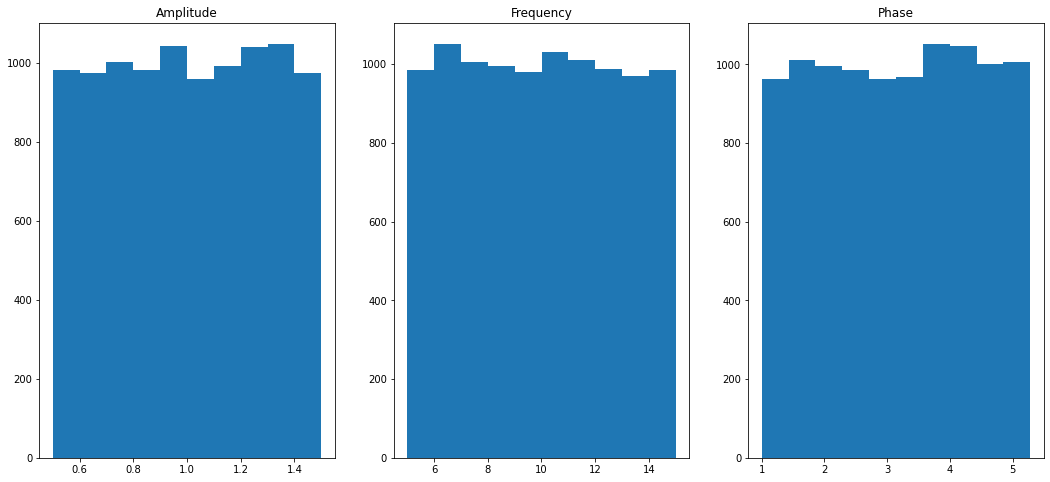

In [25]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=False)
model_pulse_clean = getmodel(X_train, y_train, filename=path+'model_pulse_clean', loadmodel=load_models)

63/63 [==============================] - 1s 2ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1377


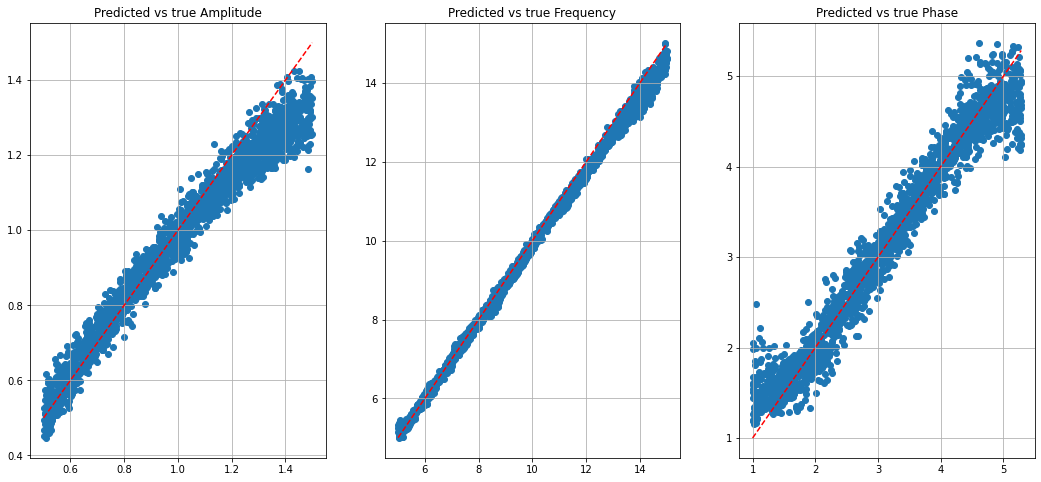

In [26]:
df_y_predict = test_and_predict(model_pulse_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

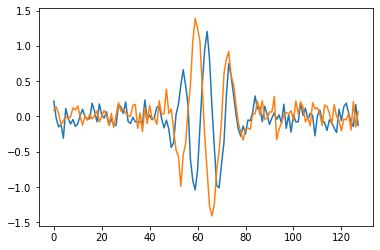

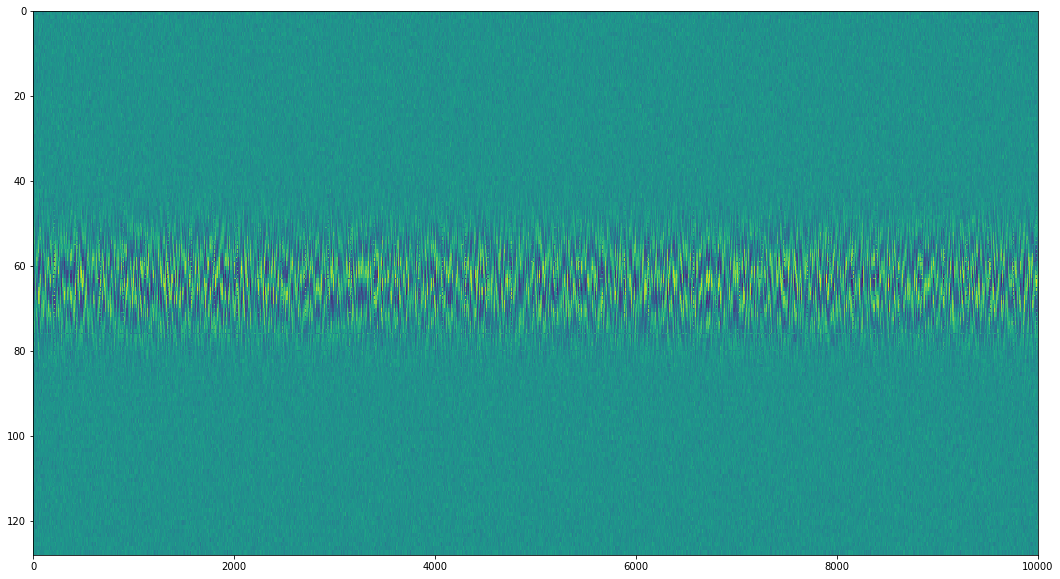

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_noisy


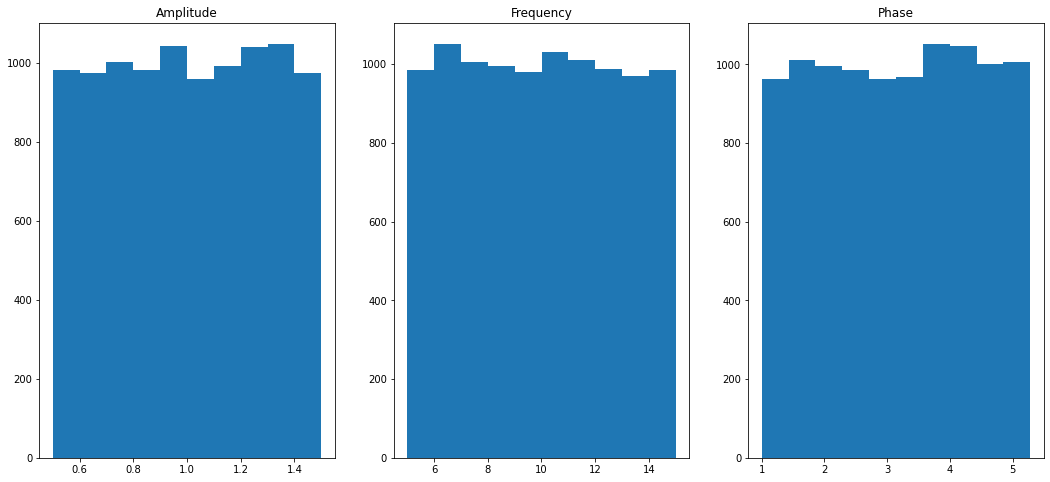

In [27]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=True)
model_pulse_noisy = getmodel(X_train, y_train, filename=path+'model_pulse_noisy', loadmodel=load_models)

# Pulse with timeshift


## Helper functions

In [28]:
def makepulsetimes(pulse, times, samplingfreq=128, t_end=1):
  dt = 1/samplingfreq
  samples = samplingfreq*t_end
  t_array = np.arange(0, t_end, dt)
  events = np.zeros(samples)
  #print(type(times))
  if type(times) is list:
    #print('this is a list')
    idx = [int(x / dt) for x in times]
  else: 
    idx = int(times / dt)
  events[idx] = 1
  filtered = signal.convolve(events, pulse, mode='same')
  return filtered

In [29]:
def makerandomtimeshift(n, min, max, seed=42):
  rng = np.random.default_rng(seed)
  times = rng.uniform(low=min, high=max, size=n)
  d = {'Timeshift': times}
  return pd.DataFrame(data=d)

## Main section

In [30]:
df_iterations_timeshifts = makerandomtimeshift(len(df_iterations), 0.1, 0.9)
df_iterations_w_timeshifts = df_iterations.join(df_iterations_timeshifts)

In [31]:
pulse_timeshift_traces_clean = [makepulsetimes(row[0], row[1]) for row in zip(pulse_traces_clean, df_iterations_w_timeshifts['Timeshift'])]

### Clean

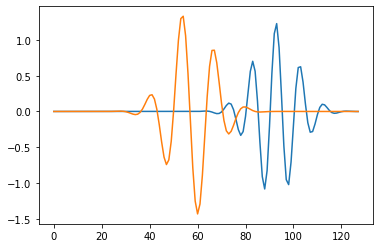

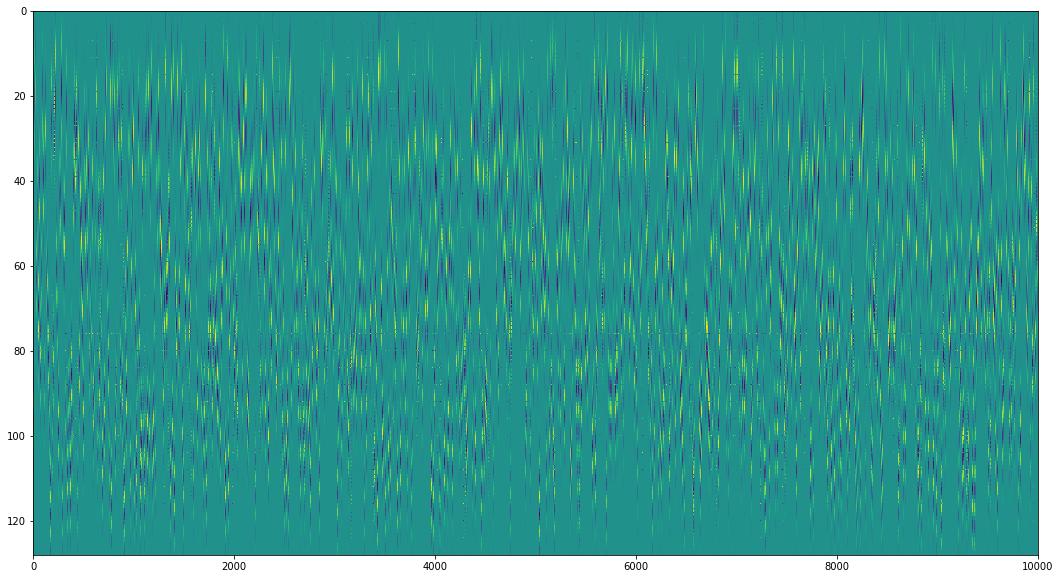

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_timeshift_clean


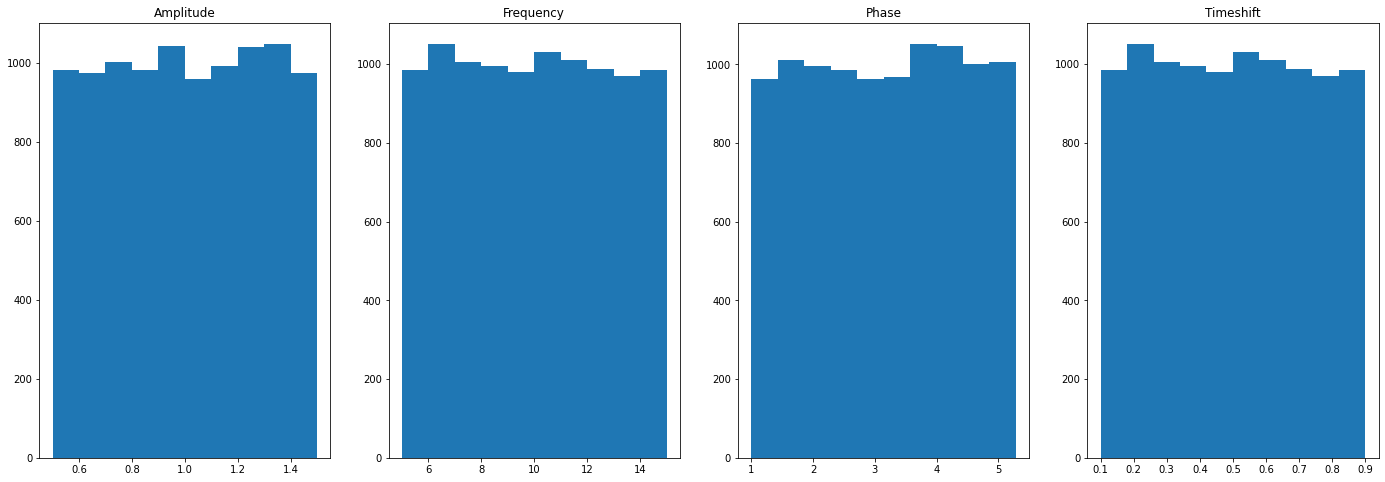

In [32]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=False)
model_pulse_timeshift_clean = getmodel(X_train, y_train, filename=path+'model_pulse_timeshift_clean', loadmodel=load_models)

63/63 [==============================] - 1s 3ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0570


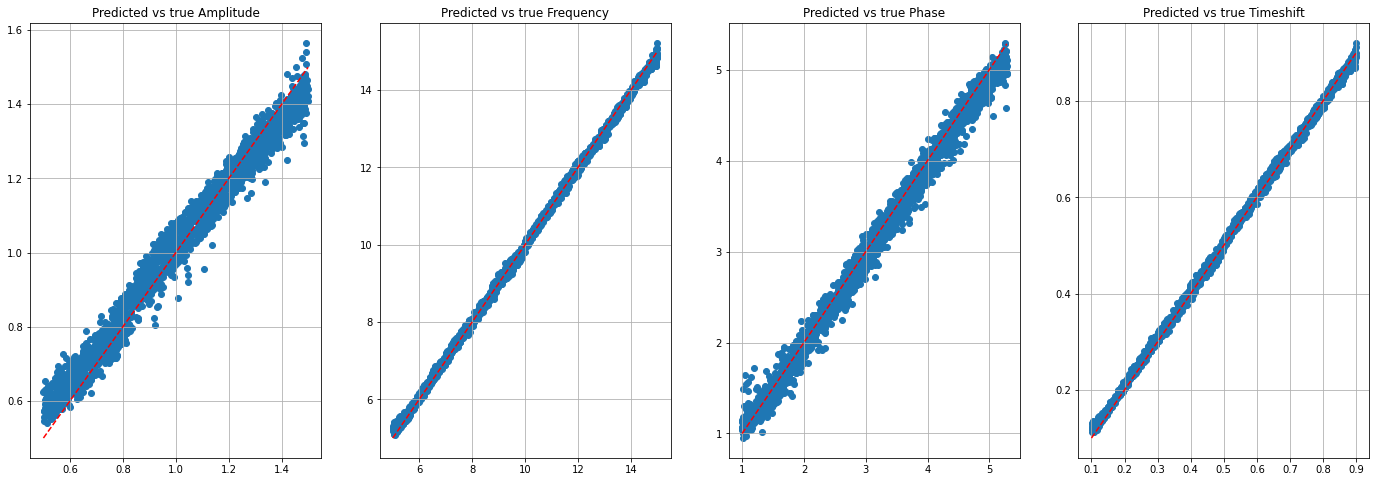

In [33]:
df_y_predict = test_and_predict(model_pulse_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

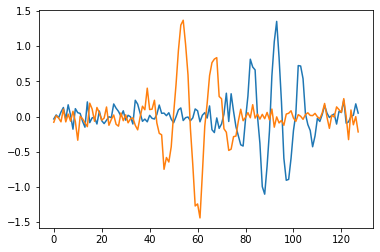

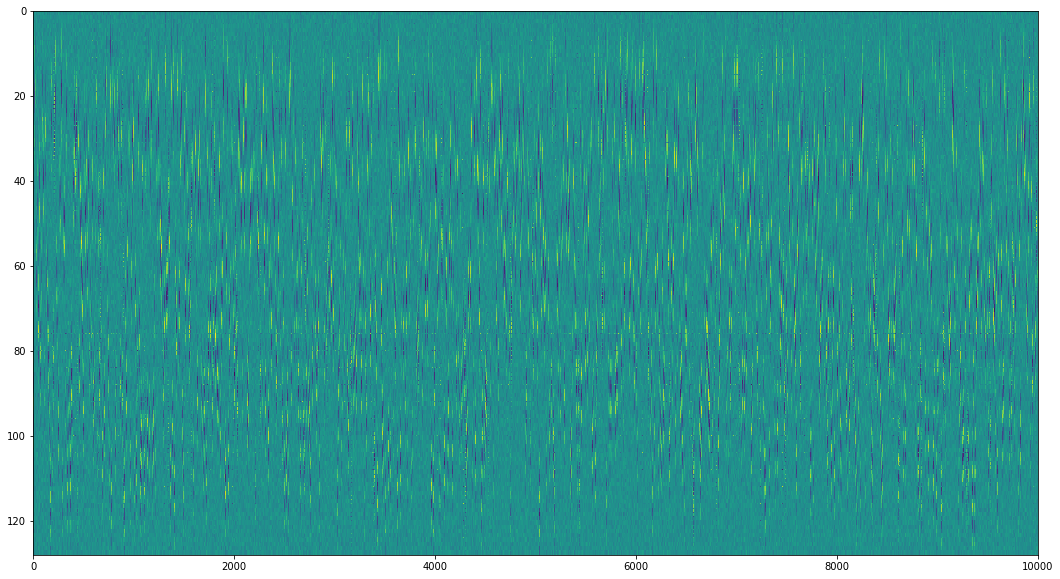

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_timeshift_noisy


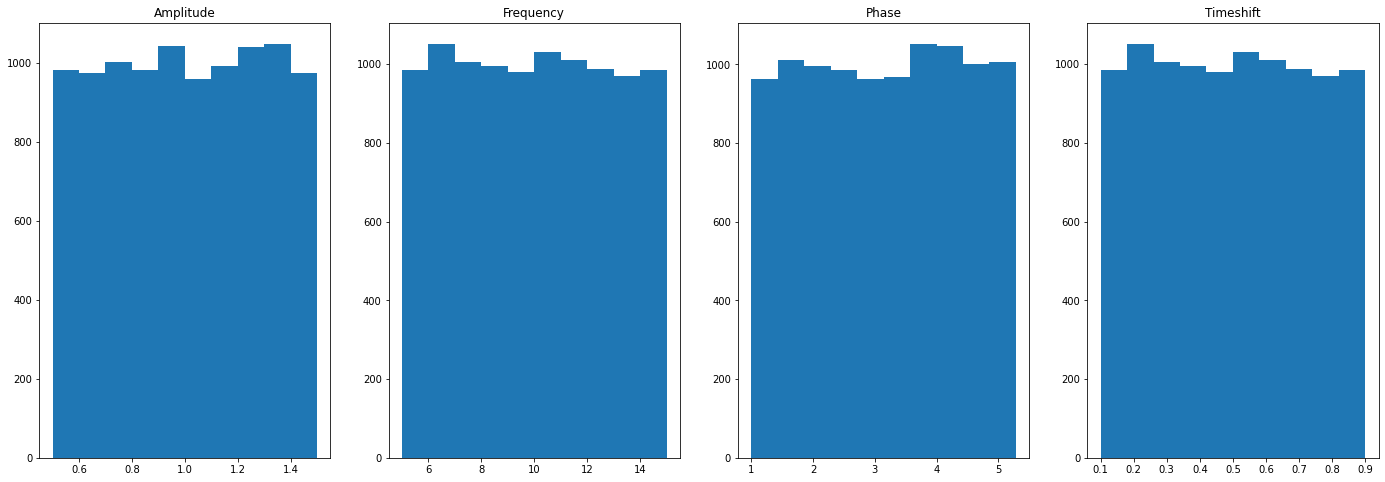

In [34]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=True)
model_pulse_timeshift_noisy = getmodel(X_train, y_train, filename=path+'model_pulse_timeshift_noisy', loadmodel=load_models)

63/63 [==============================] - 1s 3ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0784


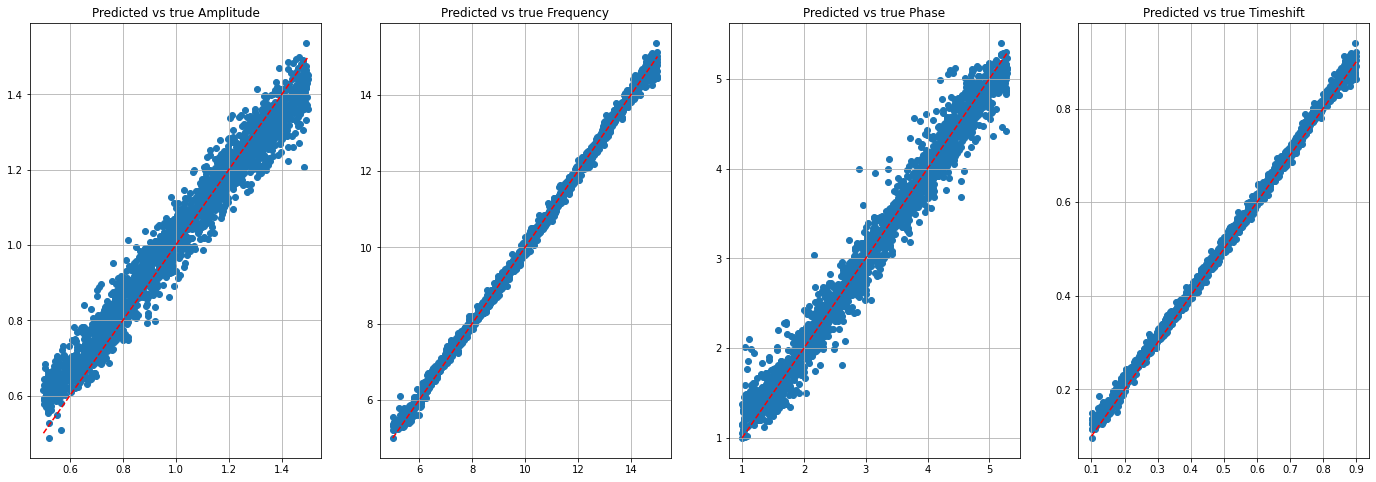

In [35]:
df_y_predict = test_and_predict(model_pulse_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# 2 Pulses with variable timeshift

## Main Section

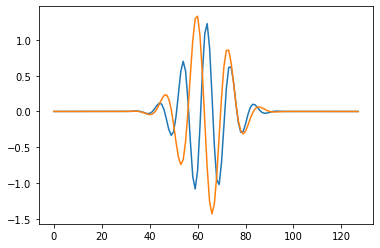

In [36]:
plt.plot(pulse_traces_clean[0])
plt.plot(pulse_traces_clean[1])

In [37]:
df_timeshift_1 = makerandomtimeshift(dataset_size, 0.1, 0.4, seed=1)
df_timediff = makerandomtimeshift(dataset_size, 0.1, 0.5, seed=2)
df_timeshift_1.rename(columns={'Timeshift': 'Time1'}, inplace=True)
df_timediff.rename(columns={'Timeshift': 'Timediff'}, inplace=True)
df_2_pulses_timeshift_iterations = df_timeshift_1.join(df_timediff)

In [38]:
timinglist = list((df_2_pulses_timeshift_iterations['Time1'], df_2_pulses_timeshift_iterations['Time1'] + df_2_pulses_timeshift_iterations['Timediff']))
pulse_2_timeshift_traces_clean = [makepulsetimes(row[0], list((row[1], row[2]))) for row in zip(pulse_traces_clean, timinglist[0], timinglist[1])]

In [39]:
df_2_pulses_timeshift_iterations_combined = df_iterations.join(df_2_pulses_timeshift_iterations)

### Clean

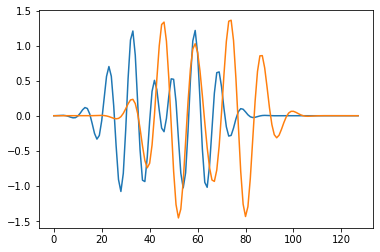

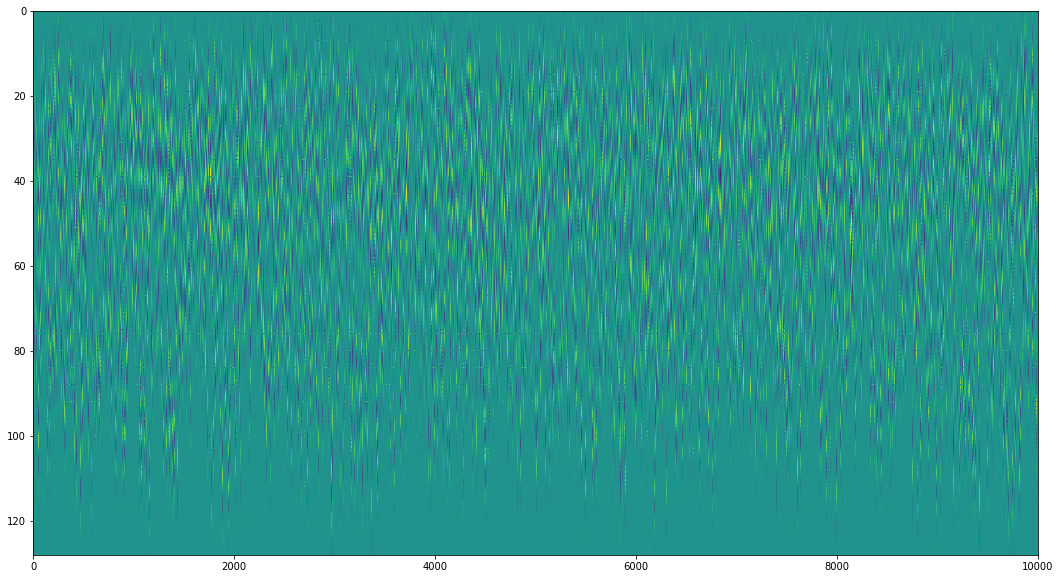

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_2_pulses_timeshift_clean


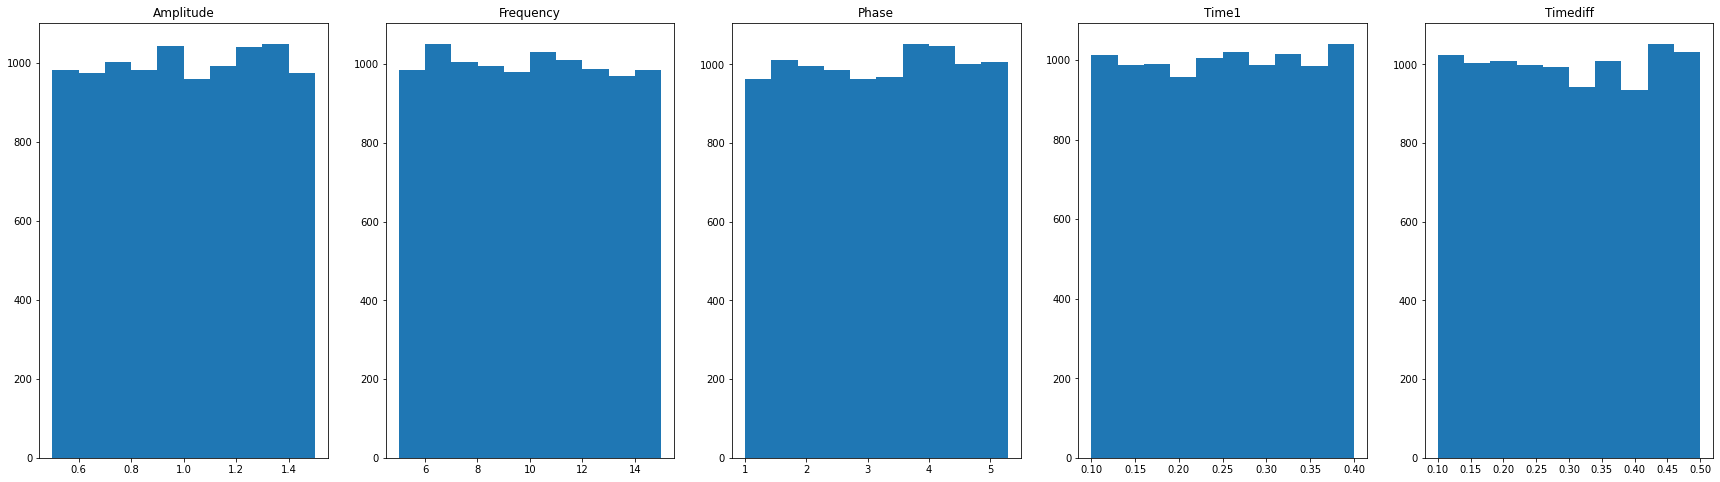

In [40]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=False)
model_2_pulses_timeshift_clean = getmodel(X_train, y_train, filename=path+'model_2_pulses_timeshift_clean', loadmodel=load_models)

63/63 [==============================] - 1s 3ms/step - loss: 0.3856 - mse: 0.3856 - mae: 0.3110


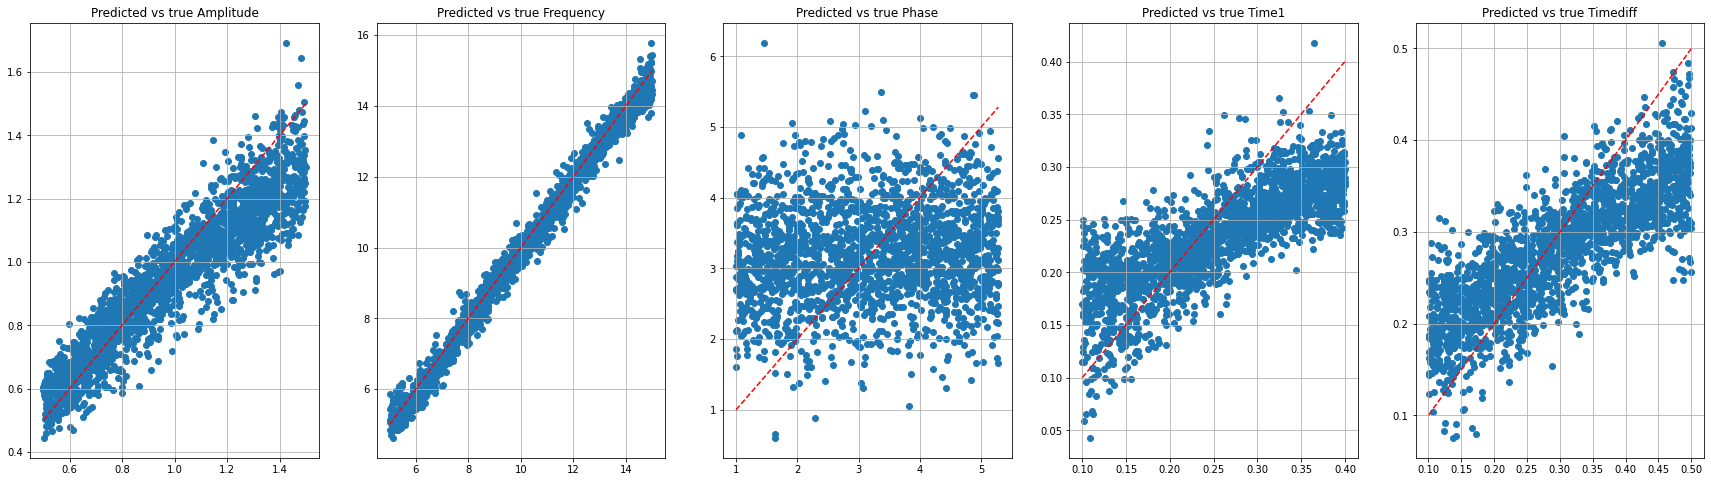

In [41]:
df_y_predict = test_and_predict(model_2_pulses_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

Noisy

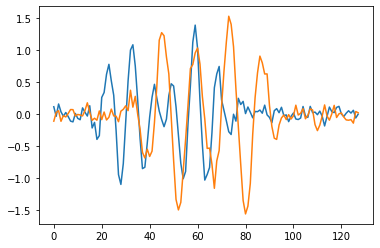

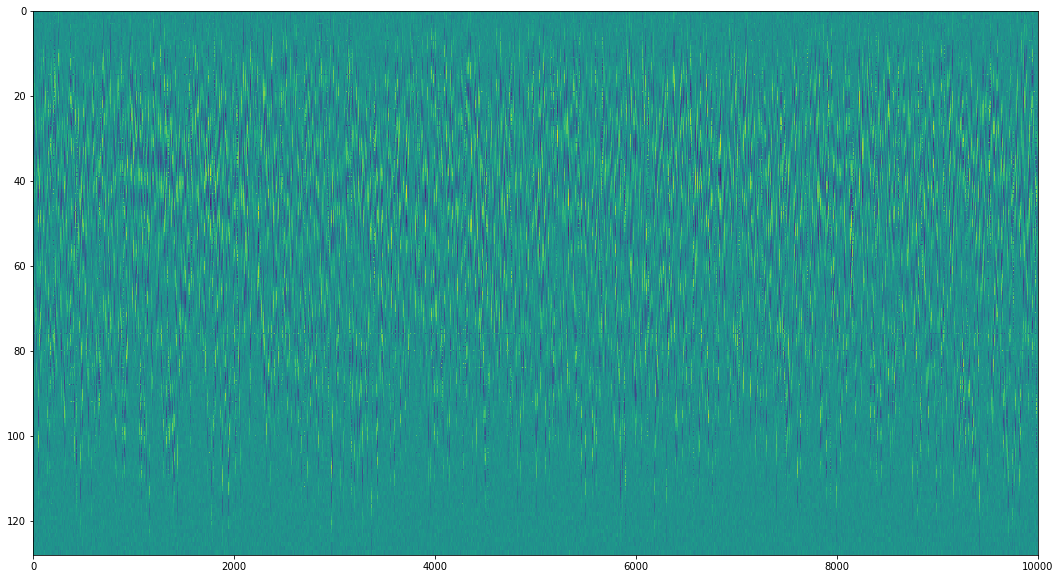

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_2_pulses_timeshift_noisy


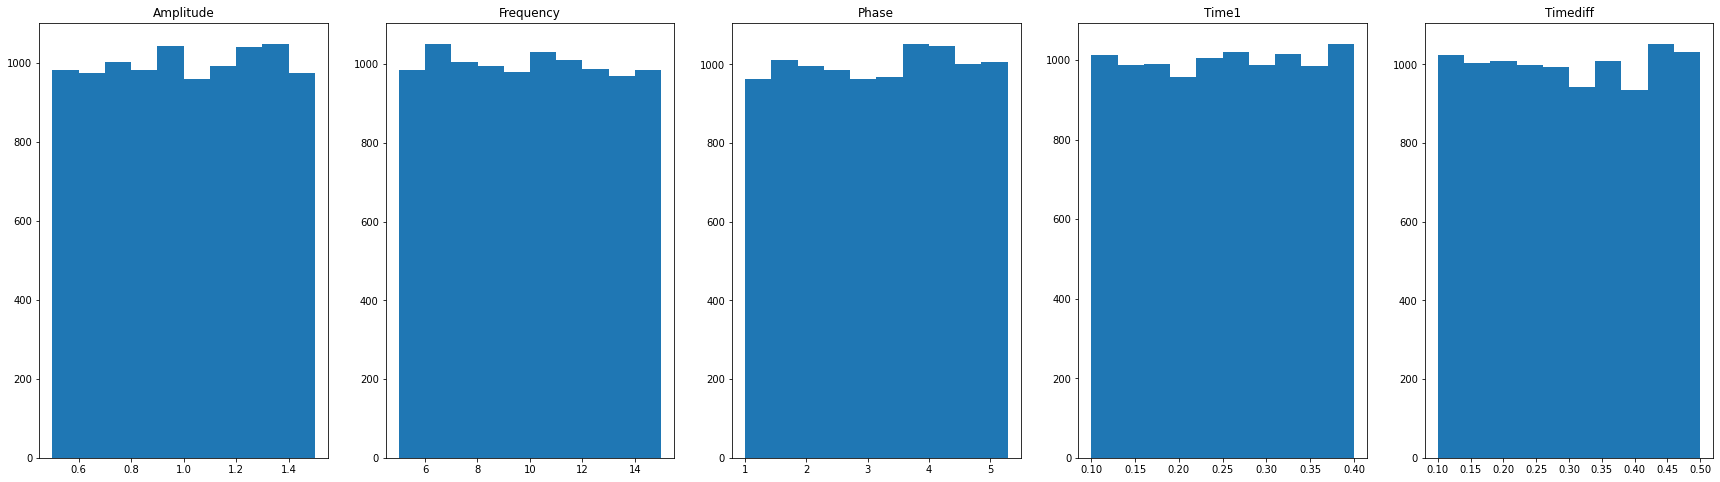

In [42]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=True)
model_2_pulses_timeshift_noisy = getmodel(X_train, y_train, filename=path+'model_2_pulses_timeshift_noisy', loadmodel=load_models)

63/63 [==============================] - 1s 3ms/step - loss: 0.4775 - mse: 0.4775 - mae: 0.3565


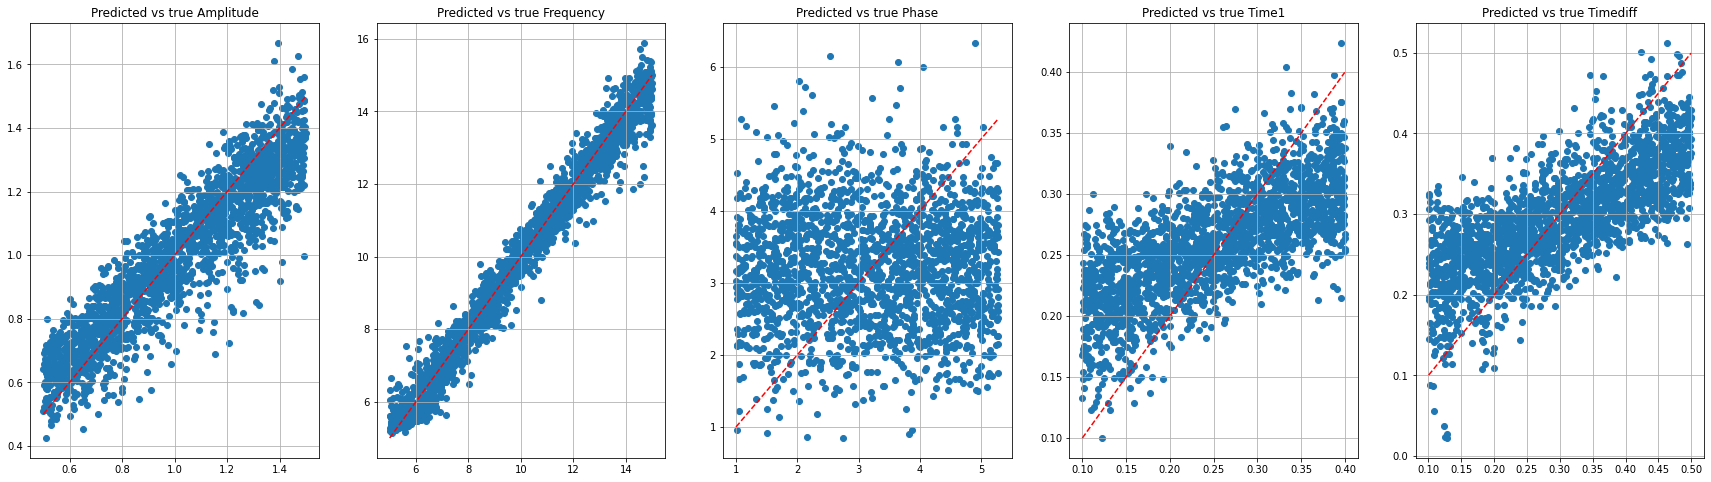

In [43]:
df_y_predict = test_and_predict(model_2_pulses_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Noise

# Pre-Processing

## Interfering Waves